### Load all simulation complexes

Load all simulation complexes.


In [1]:
import os
from tqdm.notebook import tqdm
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

simdir = "/home/admin/gitrepos/gromacs_sims/Antimicrobial_Peptides/Pseudomonas_antibiotics/simulation"
data_dirnames = ["old_simulations", "new_simulation_complexes_param"]
simulation_dirs = []
for dirname in data_dirnames:
    data_dir = os.path.join(simdir, dirname)
    try:
        for entry in sorted(os.listdir(data_dir)):
            if 'pdb' in entry.lower():
                continue
            fullpath = os.path.join(data_dir, entry)
            if os.path.isdir(fullpath):
                simulation_dirs.append(fullpath)
    except FileNotFoundError:
        # skip missing data_dir
        continue


Prepare protlig tpr selections for each complex (unless it already exists from old PP)

In [ ]:
import subprocess
import glob
import re


for sys in simulation_dirs:
    complex_name = os.path.basename(sys)
    print(complex_name)
    xtc_files = glob.glob(os.path.join(sys, '*_cluster_center_traj.xtc'))
    if not xtc_files:
        print(f"No cluster_center_traj.xtc found in {sys}, skipping...")
        continue

    xtc_file = xtc_files[0]
    m = re.search(r'([^_/\\]+)_cluster_center_traj\.xtc$', os.path.basename(xtc_file))
    if not m:
        print(f"Couldn't parse ligand name from {xtc_file}, skipping...")
        continue

    ligname = m.group(1)
    tpr_file = os.path.join(sys, f"prot_{complex_name}_{ligname}_gppmd.tpr")
    index_file = os.path.join(sys, f"prot_{complex_name}_{ligname}_index.ndx")
    out_tpr = os.path.join(sys, f"prot_{complex_name}_{ligname}_protlig.tpr")
    selection_str = "Protein_Other"
    if os.path.exists(out_tpr):
        print(f"protlig tpr already exists for {complex_name}, skipping...")
        continue
    # try the plain gmx binary first, fall back to gmx_mpi if needed
    gmxbinary = "gmx"
    cmd = [gmxbinary, "convert-tpr", "-s", tpr_file,"-n", index_file, "-o", out_tpr]
    print(f"Running command: {' '.join(cmd)}")
    try:
        # Many gmx commands accept interactive input; provide the selection string on stdin.
        # ensure a newline so the program receives the entry as if typed.
        try:
            # Source GMXRC in a bash login shell and capture the resulting environment,
            # then merge it into the current process environment so "gmx" is available.
            res = subprocess.run(
                ["bash", "-lc", "source /usr/local/gromacs/bin/GMXRC >/dev/null 2>&1 && env -0"],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                text=True,
                check=True,
            )
            for kv in res.stdout.split("\0"):
                if not kv:
                    continue
                k, v = kv.split("=", 1)
                os.environ[k] = v
        except subprocess.CalledProcessError as exc:
            print(f"Warning: could not source GMXRC: {exc.stderr.strip()}")
        proc = subprocess.run(cmd, input=selection_str + "\n", text=True,
                            stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
    except (subprocess.CalledProcessError, FileNotFoundError) as exc:
        # try next binary if first fails, otherwise raise after last attempt
        last_exc = exc
        continue

Now, prepare MDAnalysis universes for each complex

In [2]:
complexes = {}

for dir in tqdm(simulation_dirs):
    complex_name = os.path.basename(dir)
    topol_file = [f for f in os.listdir(os.path.join(data_dir, dir)) if f.endswith('protlig.tpr')][0]
    traj_file = [f for f in os.listdir(os.path.join(data_dir, dir)) if f.endswith('cluster_center_traj.xtc')][0]
    complexes[complex_name] = mda.Universe(os.path.join(data_dir, dir, topol_file),
                                os.path.join(data_dir, dir, traj_file))

  0%|          | 0/24 [00:00<?, ?it/s]

### Calculate all RMSD values and load in a dataframe

Using nproc=16


  0%|          | 0/24 [00:00<?, ?it/s]

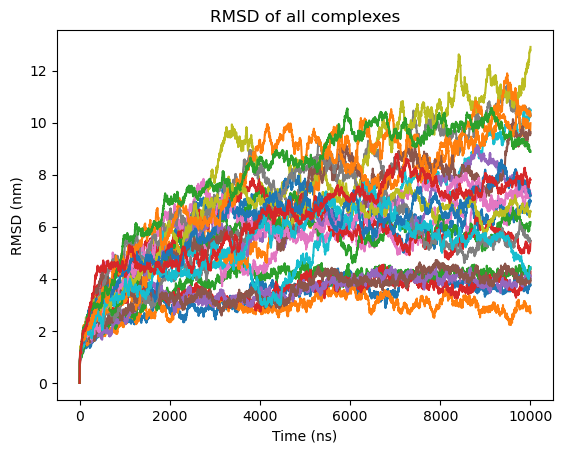

In [ ]:
from multiprocessing import Pool, cpu_count
import os
import pandas as pd

def _compute_rmsd_task(args):
    complexname, topol_path, traj_path = args
    import MDAnalysis as mda
    from MDAnalysis.analysis import rms
    u = mda.Universe(topol_path, traj_path)
    R = rms.RMSD(u, u, select='backbone', ref_frame=0)
    R.run(verbose=False)
    times = R.results.rmsd[:, 1]
    rmsd = R.results.rmsd[:, 2]
    return complexname, times, rmsd

# Build list of (name, topol_path, traj_path) so worker processes don't need non-picklable Universe objects
tasks = []
for d in simulation_dirs:
    topol_file = [f for f in os.listdir(os.path.join(data_dir, d)) if f.endswith('protlig.tpr')][0]
    traj_file = [f for f in os.listdir(os.path.join(data_dir, d)) if f.endswith('cluster_center_traj.xtc')][0]
    tasks.append((d, os.path.join(data_dir, d, topol_file), os.path.join(data_dir, d, traj_file)))

rmsd_df = None
# If SLURM_CPUS_PER_TASK is set, use it (fall back to previously computed nproc)
slurm_cpus = os.environ.get('SLURM_CPUS_PER_TASK')
if slurm_cpus:
    try:
        nproc_env = int(slurm_cpus)
        if nproc_env > 0:
            nproc = nproc_env
    except ValueError:
        pass

# Ensure we don't request more processes than logical CPUs
nproc = max(1, min(nproc, cpu_count()))

print(f"Using nproc={nproc}")
with Pool(processes=nproc) as pool:
    for complexname, times, rmsd in tqdm(pool.imap_unordered(_compute_rmsd_task, tasks), total=len(tasks)):
        if rmsd_df is None:
            rmsd_df = pd.DataFrame({'Time': times})
        rmsd_df[complexname] = rmsd

# Prepare and display the plot.
rmsd_df.set_index('Time', inplace=True)
rmsd_df.plot(legend=False)
plt.xlabel('Time (ns)')
plt.ylabel('RMSD (nm)')
plt.title('RMSD of all complexes')
#plt.legend(title='Complex')
plt.show()


### Calculate all RMSF and load in a dictionary

In [5]:
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis import rms
import numpy as _np

# build tasks: (complexname, topol_path, traj_path)
tasks = []
for complexname in complexes.keys():
    dirpath = next((d for d in simulation_dirs if os.path.basename(d) == complexname), None)
    if dirpath is None:
        continue
    try:
        topol_file = [f for f in os.listdir(dirpath) if f.endswith('protlig.tpr')][0]
        traj_file = [f for f in os.listdir(dirpath) if f.endswith('cluster_center_traj.xtc')][0]
    except IndexError:
        # skip if files not found
        continue
    tasks.append((complexname, os.path.join(dirpath, topol_file), os.path.join(dirpath, traj_file)))

# worker (override previous broken definition)
def _compute_rmsf_task(args):
    complexname, topol_path, traj_path = args

    u = mda.Universe(topol_path, traj_path)
    sel = u.select_atoms('backbone and name CA')
    R = rms.RMSF(sel).run(verbose=False)
    resids = _np.array(sel.resids)
    rmsf = _np.array(R.results.rmsf)
    return complexname, resids, rmsf

# run in parallel and collect results
rmsf_dict = {}
with Pool(processes=nproc) as p:
    for complexname, resids, rmsf in tqdm(p.imap_unordered(_compute_rmsf_task, tasks), total=len(tasks)):
        rmsf_dict[f'{complexname}_resid'] = resids
        rmsf_dict[f'{complexname}_rmsf'] = rmsf

  0%|          | 0/24 [00:00<?, ?it/s]

### Calculate all Radii of Gyration and load in a dataframe 

  0%|          | 0/24 [00:00<?, ?it/s]

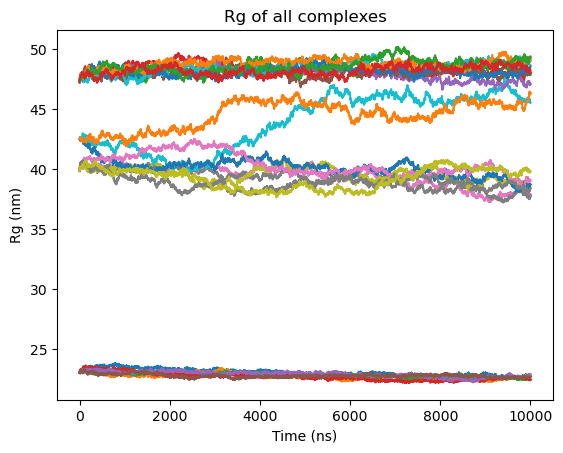

In [7]:
import pandas as pd
from MDAnalysis.analysis import rms
import MDAnalysis as mda
import numpy as _np
# build tasks list of (complexname, topol_path, traj_path) so worker processes create their own Universe
rg_tasks = []
for d in simulation_dirs:
    complexname = os.path.basename(d)
    try:
        topol_file = [f for f in os.listdir(d) if f.endswith('protlig.tpr')][0]
        traj_file = [f for f in os.listdir(d) if f.endswith('cluster_center_traj.xtc')][0]
    except IndexError:
        # skip directories missing required files
        continue
    rg_tasks.append((complexname, os.path.join(d, topol_file), os.path.join(d, traj_file)))

def _compute_rg_task(args):
    complexname, topol_path, traj_path = args
    u = mda.Universe(topol_path, traj_path)
    group = u.select_atoms('protein')
    times = []
    rg = []
    for ts in u.trajectory:
        times.append(ts.time)
        rg.append(group.radius_of_gyration())
    return complexname, _np.array(times), _np.array(rg)

rg_df = None
with Pool(processes=nproc) as pool:
    for complexname, times_arr, rg_arr in tqdm(pool.imap_unordered(_compute_rg_task, rg_tasks), total=len(rg_tasks)):
        if rg_df is None:
            rg_df = pd.DataFrame({'Time': times_arr})
        rg_df[complexname] = rg_arr

# Prepare and display the plot.
rg_df.set_index('Time', inplace=True)
rg_df.plot(legend=False)
plt.xlabel('Time (ns)')
plt.ylabel('Rg (nm)')
plt.title('Rg of all complexes')
plt.show()

### Number of hydrogen bonds between protein and ligand

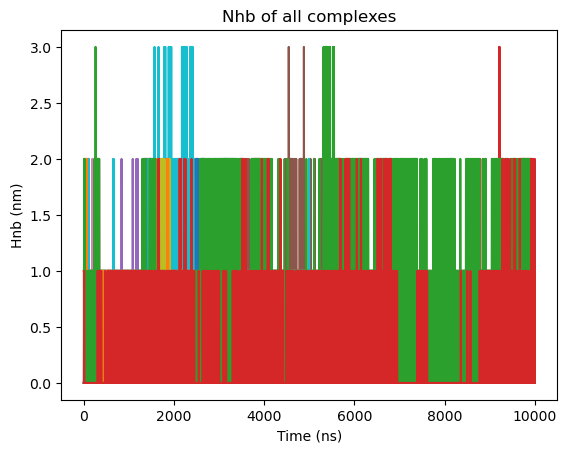

In [10]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import numpy as np
import pandas as pd
import os
from multiprocessing import Pool
import numpy as _np
import MDAnalysis as mda
import warnings
import logging
warnings.filterwarnings("ignore")

logging.getLogger("MDAnalysis").setLevel(logging.ERROR)
logging.getLogger("matplotlib").setLevel(logging.ERROR)

# suppress numpy runtime warnings (e.g. divide by zero, invalid)
_np.seterr(all='ignore')
hb_dict = {}
# build tasks: (complexname, topol_path, traj_path)
tasks_hb = []
for complexname in list(complexes.keys()):
    dirpath = next((d for d in simulation_dirs if os.path.basename(d) == complexname), None)
    if dirpath is None:
        continue
    try:
        topol_file = [f for f in os.listdir(dirpath) if f.endswith('protlig.tpr')][0]
        traj_file = [f for f in os.listdir(dirpath) if f.endswith('cluster_center_traj.xtc')][0]
    except IndexError:
        continue
    tasks_hb.append((complexname, os.path.join(dirpath, topol_file), os.path.join(dirpath, traj_file)))

# Temporarily prevent the serial loop below from executing by emptying complexes,
# we'll restore it after the parallel work.
_orig_complexes = complexes
complexes = {}

def _hba_worker(args):
    complexname, topol_path, traj_path = args

    u = mda.Universe(topol_path, traj_path)
    hbs = HBA(universe=u, update_selections=False)
    hbs.donors_sel = hbs.guess_donors("protein")
    hbs.hydrogens_sel = hbs.guess_hydrogens("protein")
    hbs.acceptors_sel = hbs.guess_acceptors("not protein")
    hbs.run(verbose=False)
    ligand_indices = u.select_atoms(hbs.acceptors_sel).indices

    hbs_reversed = HBA(universe=u, update_selections=False)
    hbs_reversed.donors_sel = hbs.guess_donors("not protein")
    hbs_reversed.hydrogens_sel = hbs.guess_hydrogens("not protein")
    hbs_reversed.acceptors_sel = hbs.guess_acceptors("protein")
    hbs_reversed.run(verbose=False)

    # filter to intermolecular bonds (protein <-> ligand)
    filtered = []
    for hb in hbs.results.hbonds:
        frame, donor_idx, hydrogen_idx, acceptor_idx, da_dist, da_angle = hb
        if (donor_idx not in ligand_indices and acceptor_idx in ligand_indices) or \
        (donor_idx in ligand_indices and acceptor_idx not in ligand_indices):
            filtered.append(hb)

    for hb in hbs_reversed.results.hbonds:
        frame, donor_idx, hydrogen_idx, acceptor_idx, da_dist, da_angle = hb
        if (donor_idx not in ligand_indices and acceptor_idx in ligand_indices) or \
        (donor_idx in ligand_indices and acceptor_idx not in ligand_indices):
            filtered.append(hb)

    filtered = np.array(filtered)

    # counts per frame (nhb)
    times = hbs.times
    if filtered.size == 0:
        nhb = _np.zeros_like(times, dtype=int)
    else:
        frames = filtered[:, 0].astype(int)
        nhb = _np.bincount(frames, minlength=len(times))[:len(times)]

    n_frames = hbs.n_frames

    # counts by (donor, hydrogen, acceptor)
    if filtered.size == 0:
        count_ids = _np.empty((0, 4), dtype=int)
    else:
        ids = filtered[:, 1:4].astype(int)
        uniq, counts = _np.unique(ids, axis=0, return_counts=True)
        count_ids = _np.hstack((uniq, counts.reshape(-1, 1))).astype(int)

    return complexname, {
        "hbonds": filtered,
        "times": times,
        "nhb": nhb,
        "n_frames": n_frames,
        "count_ids": count_ids,
    }

# Run workers and build hb_dict with lightweight stubs compatible with later code
hb_dict = {}
with Pool(processes=nproc) as pool:
    for complexname, data in pool.imap_unordered(_hba_worker, tasks_hb):
        class _HBAStub:
            def __init__(self, d):
                self.results = type("R", (), {})()
                self.results.hbonds = d["hbonds"]
                self.times = d["times"]
                self.n_frames = d["n_frames"]
                self._nhb = d["nhb"]
                self._count_ids = d["count_ids"]
            def count_by_time(self):
                return self._nhb
            def count_by_ids(self):
                return self._count_ids

        hb_dict[complexname] = _HBAStub(data)
# Restore complexes dictionary for potential later use
complexes = _orig_complexes
nhb_df = None
for complexname, hbs in hb_dict.items():
    times = hbs.times
    nhb = hbs.count_by_time()
    # For the first complex, initialize the DataFrame with the time column.
    if nhb_df is None:
        nhb_df = pd.DataFrame({'Time': times})
        
    # Add the RMSD values for the current complex to the DataFrame.
    nhb_df[complexname] = nhb
# Prepare and display the plot.
# Prepare and display the plot.
nhb_df.set_index('Time', inplace=True)
nhb_df.plot(legend=False)
plt.xlabel('Time (ns)')
plt.ylabel('Hnb (nm)')
plt.title('Nhb of all complexes')
plt.show()

In [21]:
from IPython.display import display

# find and show columns in nhb_df that contain only zeros
try:
    nhb_df  # ensure variable exists
except NameError:
    print("nhb_df is not defined in the current notebook.")
else:
    zero_cols = [c for c in nhb_df.columns if nhb_df[c].eq(0).all()]
    if not zero_cols:
        print("No columns contain only zeros.")
    else:
        print(f"Columns with all zeros ({len(zero_cols)}):")
        for name in zero_cols:
            print(" -", name)
        # display the data for those columns (useful in Jupyter)
        try:
            display(nhb_df[zero_cols])
        except Exception:
            print(nhb_df[zero_cols].head())

Columns with all zeros (1):
 - aminostep2012C


,aminostep2012C
Time,
0.0,0
2.0,0
4.0,0
6.0,0
8.0,0
...,...
9992.0,0
9994.0,0
9996.0,0


### Plot everything

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.axes as maxes
_original_axis = maxes.Axes.axis

def new_axis(self, *args, **kwargs):
    if args and args[0] == 'off':
        return self  # Skip turning off the axes
    return _original_axis(self, *args, **kwargs)

maxes.Axes.axis = new_axis

def add_plot(complexname, dataframe, axis, top_dict, right_df ,legend=False, topxlabel=False, bottomxlabel=False):
    axis.plot(dataframe.index/1000, dataframe[complexname], label="RMSD (nm)", color='blue')
    axis.plot(rg_df.index/1000, rg_df[complexname], label=r"$R_g$ (nm)", color='green')
    axis.set_xticks(dataframe.index[::int(len(dataframe)/4)]/1000)
    axis.set_xticklabels(dataframe.index[::int(len(dataframe)/4)]/1000)
    
    ax_top = axis.twiny()
    
    ax_top.plot(top_dict[f"{complexname}_resid"], top_dict[f"{complexname}_rmsf"], label="RMSF (nm)", color='orange')
    ticks = np.linspace(top_dict[f"{complexname}_resid"][0], top_dict[f"{complexname}_resid"][-1], 4)
    ax_top.set_xticks(ticks)
    ax_top.set_xticklabels(["{:.0f}".format(x) for x in ticks])

    ax_right = axis.twinx()
    ax_right.plot(right_df.index/1000, right_df[complexname], label=r"$N_{hb}$", color='gray', alpha=0.5)
    ymin, ymax = ax_right.get_ylim()
    ticks = np.arange(0, np.ceil(ymax),2)
    ax_right.set_yticks(ticks)
    ax_right.set_yticklabels(["{:.0f}".format(x) for x in ticks])

    if legend:
        lines, labels = axis.get_legend_handles_labels()
        top_lines, top_labels = ax_top.get_legend_handles_labels()
        right_lines, right_labels = ax_right.get_legend_handles_labels()
        axis.legend(lines + top_lines + right_lines, labels + top_labels + right_labels, 
                    loc='upper center', fontsize=10, title_fontsize=10, ncol=4)
        
        lgd = axis.get_legend()
        lgd.set_bbox_to_anchor((0.5, 1.6))
        lgd.get_frame().set_alpha(1.0)
        

    if topxlabel:
        ax_top.set_xlabel('Residue Number', fontsize=15)
    if bottomxlabel:
        axis.set_xlabel('Time (ns)', fontsize=15)    


### Hydrogen Bond occupancy statistics

In [ ]:
from tqdm.notebook import tqdm
hb_details = {}

for complex, hb in tqdm(hb_dict.items()):
    u = complexes[complex]
    ligand_indices = u.select_atoms(hb.acceptors_sel).indices
    hbstats = hb.count_by_ids()
    # Only keep bonds with occupancy more than 5%
    hbstats_filtered = hbstats[hbstats[:, -1] / hb.n_frames > 0.04]
    bond_types = []
    for bond in hbstats_filtered:
        donor_idx, hydrogen_idx, acceptor_idx, occ = bond
        donor_atom = u.atoms[int(donor_idx)]
        hydrogen_atom = u.atoms[int(hydrogen_idx)]
        acceptor_atom = u.atoms[int(acceptor_idx)]
        # Check if the donor or acceptor is a ligand
        if donor_idx in ligand_indices and acceptor_idx not in ligand_indices:
            # Donor is a ligand, acceptor is not
            bond_type = f"({donor_atom.resname}){donor_atom.name}-H::{acceptor_atom.name}({acceptor_atom.resid}-{acceptor_atom.resname}) : {occ/hb.n_frames:.2f}"
        elif acceptor_idx in ligand_indices and donor_idx not in ligand_indices:
            # Acceptor is a ligand, donor is not
            bond_type = f"({donor_atom.resid}-{donor_atom.resname}){donor_atom.name}-H::{acceptor_atom.name}({acceptor_atom.resname}) : {occ/hb.n_frames:.2f}"
        else:
            # Both donor and acceptor are ligands
            continue
        bond_types.append(bond_type)
    
    hb_details[complex] = bond_types

### Plot everything

In [ ]:
import matplotlib.pyplot as plt

def add_hist(complexname, bond_types, ax):
    # Parse the bond_types to extract bond labels and occupancy values
    labels = [b.split(" : ")[0] for b in bond_types]
    occupancies = [float(b.split(" : ")[1]) for b in bond_types]

    ax.bar(range(len(occupancies)), np.array(occupancies))
    ax.set_xticks(range(len(occupancies)), labels, rotation=90, ha='right', fontsize=11)
    #ax.set_ylabel(complexname.replace("C", "").replace('_', '-'), fontsize=12)
    ax.set_ylim(-0.02, 1.2)
    ax.set_yticks(np.linspace(0, 1, 3))


## New Layout

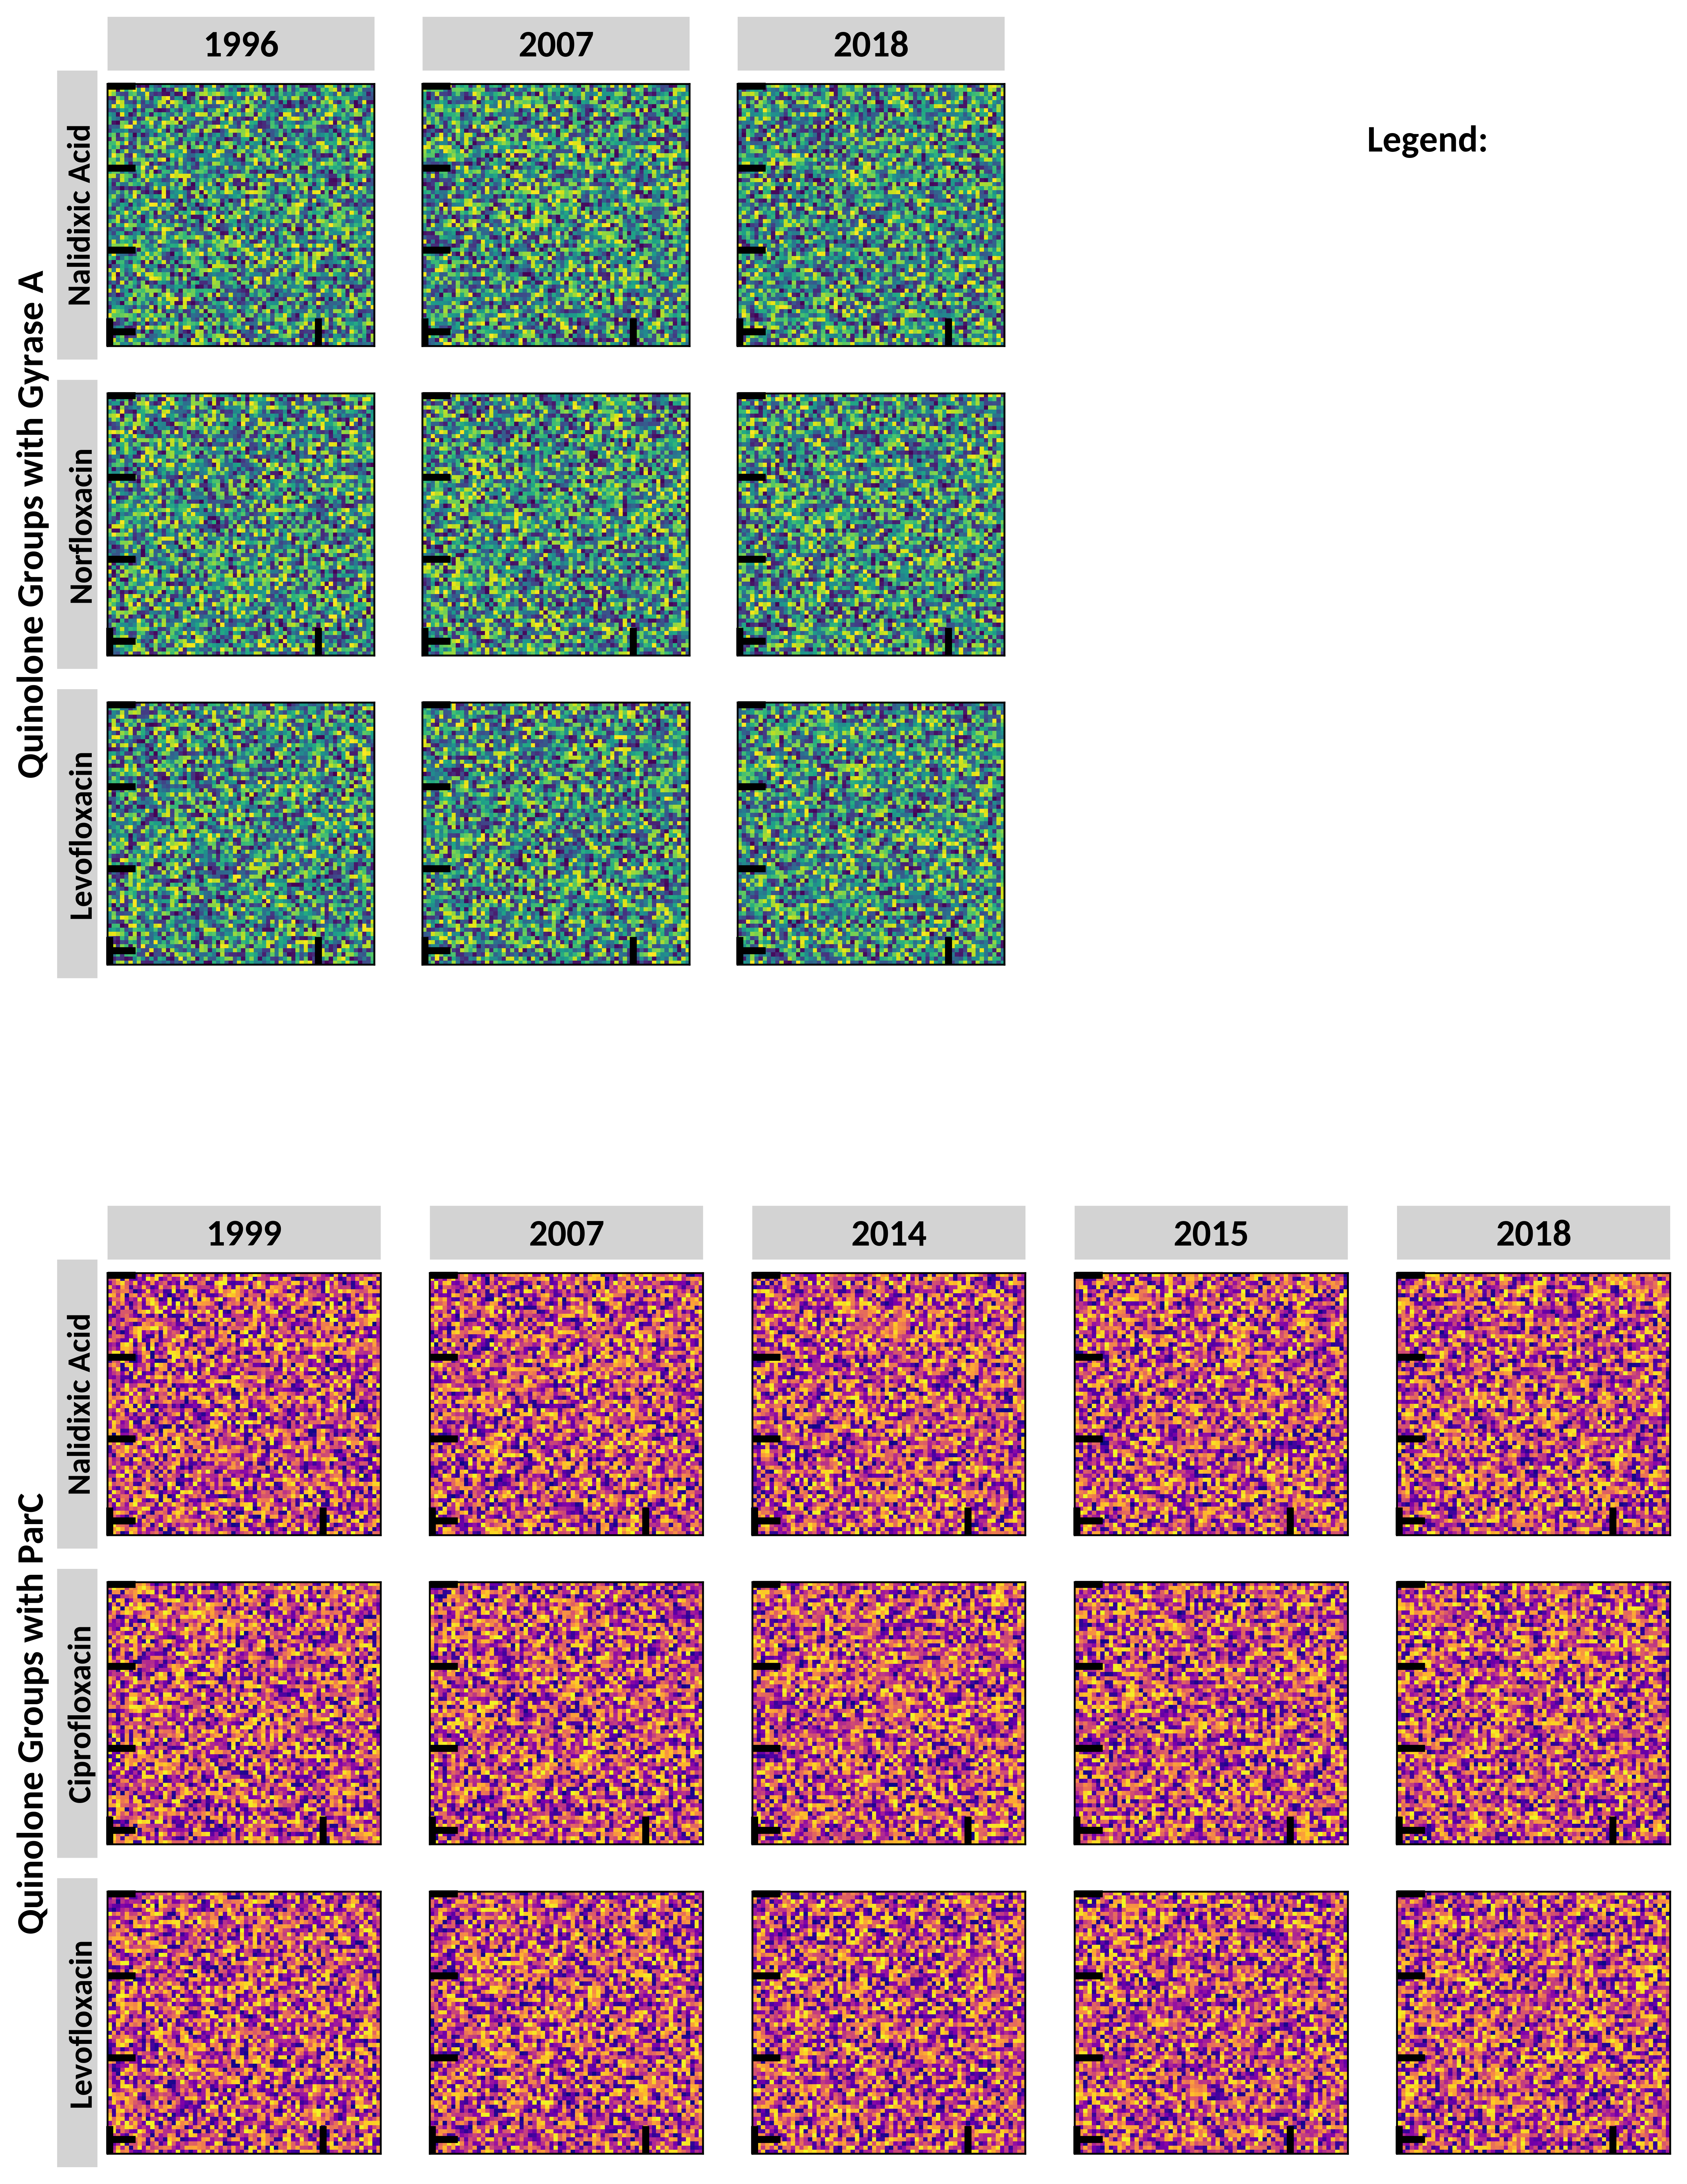

In [ ]:
# language: python
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
mpl.rcParams['axes.titlepad'] = 0
mpl.rcParams['font.family'] = 'Carlito'
mpl.rcParams['font.serif'] = ['Carlito']
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['text.usetex'] = False
from matplotlib.patches import FancyBboxPatch

fig = plt.figure(figsize=(12, 16))
# Outer: left main area + right legend column
outer = GridSpec(nrows=1, ncols=2, width_ratios=[8, 2], wspace=0.06)

# Left area subdivided into top and bottom blocks
left_blocks = outer[0, 0].subgridspec(nrows=2, ncols=4, height_ratios=[1, 1], hspace=0.35)


# Top block: 3 rows × 3 cols
top_gs = left_blocks[0,0:3].subgridspec(nrows=3, ncols=3, hspace=0.18, wspace=0.18)
top_axes = [[fig.add_subplot(top_gs[r, c]) for c in range(3)] for r in range(3)]

# Bottom block: 3 rows × 5 cols
# make the bottom block span the full figure width (both left and legend columns)
left_blocks = outer[0, :].subgridspec(nrows=2, ncols=1, height_ratios=[1, 1], hspace=0.35)
bot_gs = left_blocks[1].subgridspec(nrows=3, ncols=5, hspace=0.18, wspace=0.18)
bot_axes = [[fig.add_subplot(bot_gs[r, c]) for c in range(5)] for r in range(3)]

# Right legend / annotation column
legend_ax = fig.add_subplot(outer[0, 1])
legend_ax.axis('off')
legend_ax.text(0.0, 0.98, "Legend:", va='top', fontsize=16, weight='bold')

# Fill panels with placeholder content and hide axes ticks
for r in range(3):
    for c in range(3):
        ax = top_axes[r][c]
        ax.imshow(np.random.rand(64, 64), cmap='viridis', aspect='auto')
        #ax.axis('off')
        # hide axis label text (tick labels) but keep tick marks
        ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

for r in range(3):
    for c in range(5):
        ax = bot_axes[r][c]
        ax.imshow(np.random.rand(64, 64), cmap='plasma', aspect='auto')
        #ax.axis('off')
        # hide axis label text (tick labels) but keep tick marks
        ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

# Column headers for top block
top_years = ['1996', '2007', '2018']
for j, year in enumerate(top_years):
    pos = top_axes[0][j].get_position()
    cx = pos.x0 + pos.width / 2
    cy = pos.y1 + 0.008
    bb = FancyBboxPatch((pos.x0, cy-0.003), pos.width, 0.02,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(cx, cy, year, ha='center', va='bottom', fontsize=16, weight='bold')

# Column headers for bottom block
bot_years = ['1999', '2007', '2014', '2015', '2018']
for j, year in enumerate(bot_years):
    pos = bot_axes[0][j].get_position()
    cx = pos.x0 + pos.width / 2
    cy = pos.y1 + 0.008
    bb = FancyBboxPatch((pos.x0, cy-0.003), pos.width, 0.02,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(cx, cy, year, ha='center', va='bottom', fontsize=16, weight='bold')

# Vertical group labels (left side)
top_block_pos = top_axes[1][0].get_position()  # middle row of top block
bot_block_pos = bot_axes[1][0].get_position()  # middle row of bottom block
# compute vertical centers from actual axes positions (fixes AttributeError)
top_positions = [top_axes[r][c].get_position() for r in range(len(top_axes)) for c in range(len(top_axes[0]))]
top_y0 = min(p.y0 for p in top_positions)
top_y1 = max(p.y1 for p in top_positions)
top_center = (top_y0 + top_y1) / 2

bot_positions = [bot_axes[r][c].get_position() for r in range(len(bot_axes)) for c in range(len(bot_axes[0]))]
bot_y0 = min(p.y0 for p in bot_positions)
bot_y1 = max(p.y1 for p in bot_positions)
bot_center = (bot_y0 + bot_y1) / 2

fig.text(0.08, top_center, "Quinolone Groups with Gyrase A",
        va='center', ha='left', rotation=90, fontsize=16, weight='bold')
fig.text(0.08, bot_center, "Quinolone Groups with ParC",
        va='center', ha='left', rotation=90, fontsize=16, weight='bold')

Ligand_names = ["Nalidixic Acid", "Norfloxacin", "Levofloxacin"]

for i, name in enumerate(Ligand_names):
    pos = top_axes[i][0].get_position()
    # Create a background box for the ylabel
    ylab_box = FancyBboxPatch(
        (pos.x0 - 0.025, pos.y0 - 0.005),        # slightly lower so it doesn't overlap the label
        0.02,
        pos.height + 0.01,                      # a hair taller to sit nicely behind the label
        boxstyle="round,pad=0.0",
        transform=fig.transFigure,
        facecolor="lightgray",
        edgecolor="k",
        linewidth=0,
        zorder=0                                 # draw underneath the axis label text
    )
    fig.add_artist(ylab_box)
    bb = FancyBboxPatch((pos.x0-0.025, pos.y0), 0.02, pos.height,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(pos.x0 - 0.02, pos.y0 + pos.height / 2, name,
            va='center', ha='left', rotation=90, fontsize=14, weight='bold')


Ligand_names = ["Nalidixic Acid", "Ciprofloxacin", "Levofloxacin"]
for i, name in enumerate(Ligand_names):
    pos = bot_axes[i][0].get_position()
    # Create a background box for the ylabel
    ylab_box = FancyBboxPatch(
        (pos.x0 - 0.025, pos.y0 - 0.005),        # slightly lower so it doesn't overlap the label
        0.02,
        pos.height + 0.01,                      # a hair taller to sit nicely behind the label
        boxstyle="round,pad=0.0",
        transform=fig.transFigure,
        facecolor="lightgray",
        edgecolor="k",
        linewidth=0,
        zorder=0                                 # draw underneath the axis label text
    )
    fig.add_artist(ylab_box)
    bb = FancyBboxPatch((pos.x0-0.025, pos.y0), 0.02, pos.height,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(pos.x0 - 0.02, pos.y0 + pos.height / 2, name,
            va='center', ha='left', rotation=90, fontsize=14, weight='bold')

#plt.savefig("layout_example.svg", dpi=300, bbox_inches='tight')
plt.show()

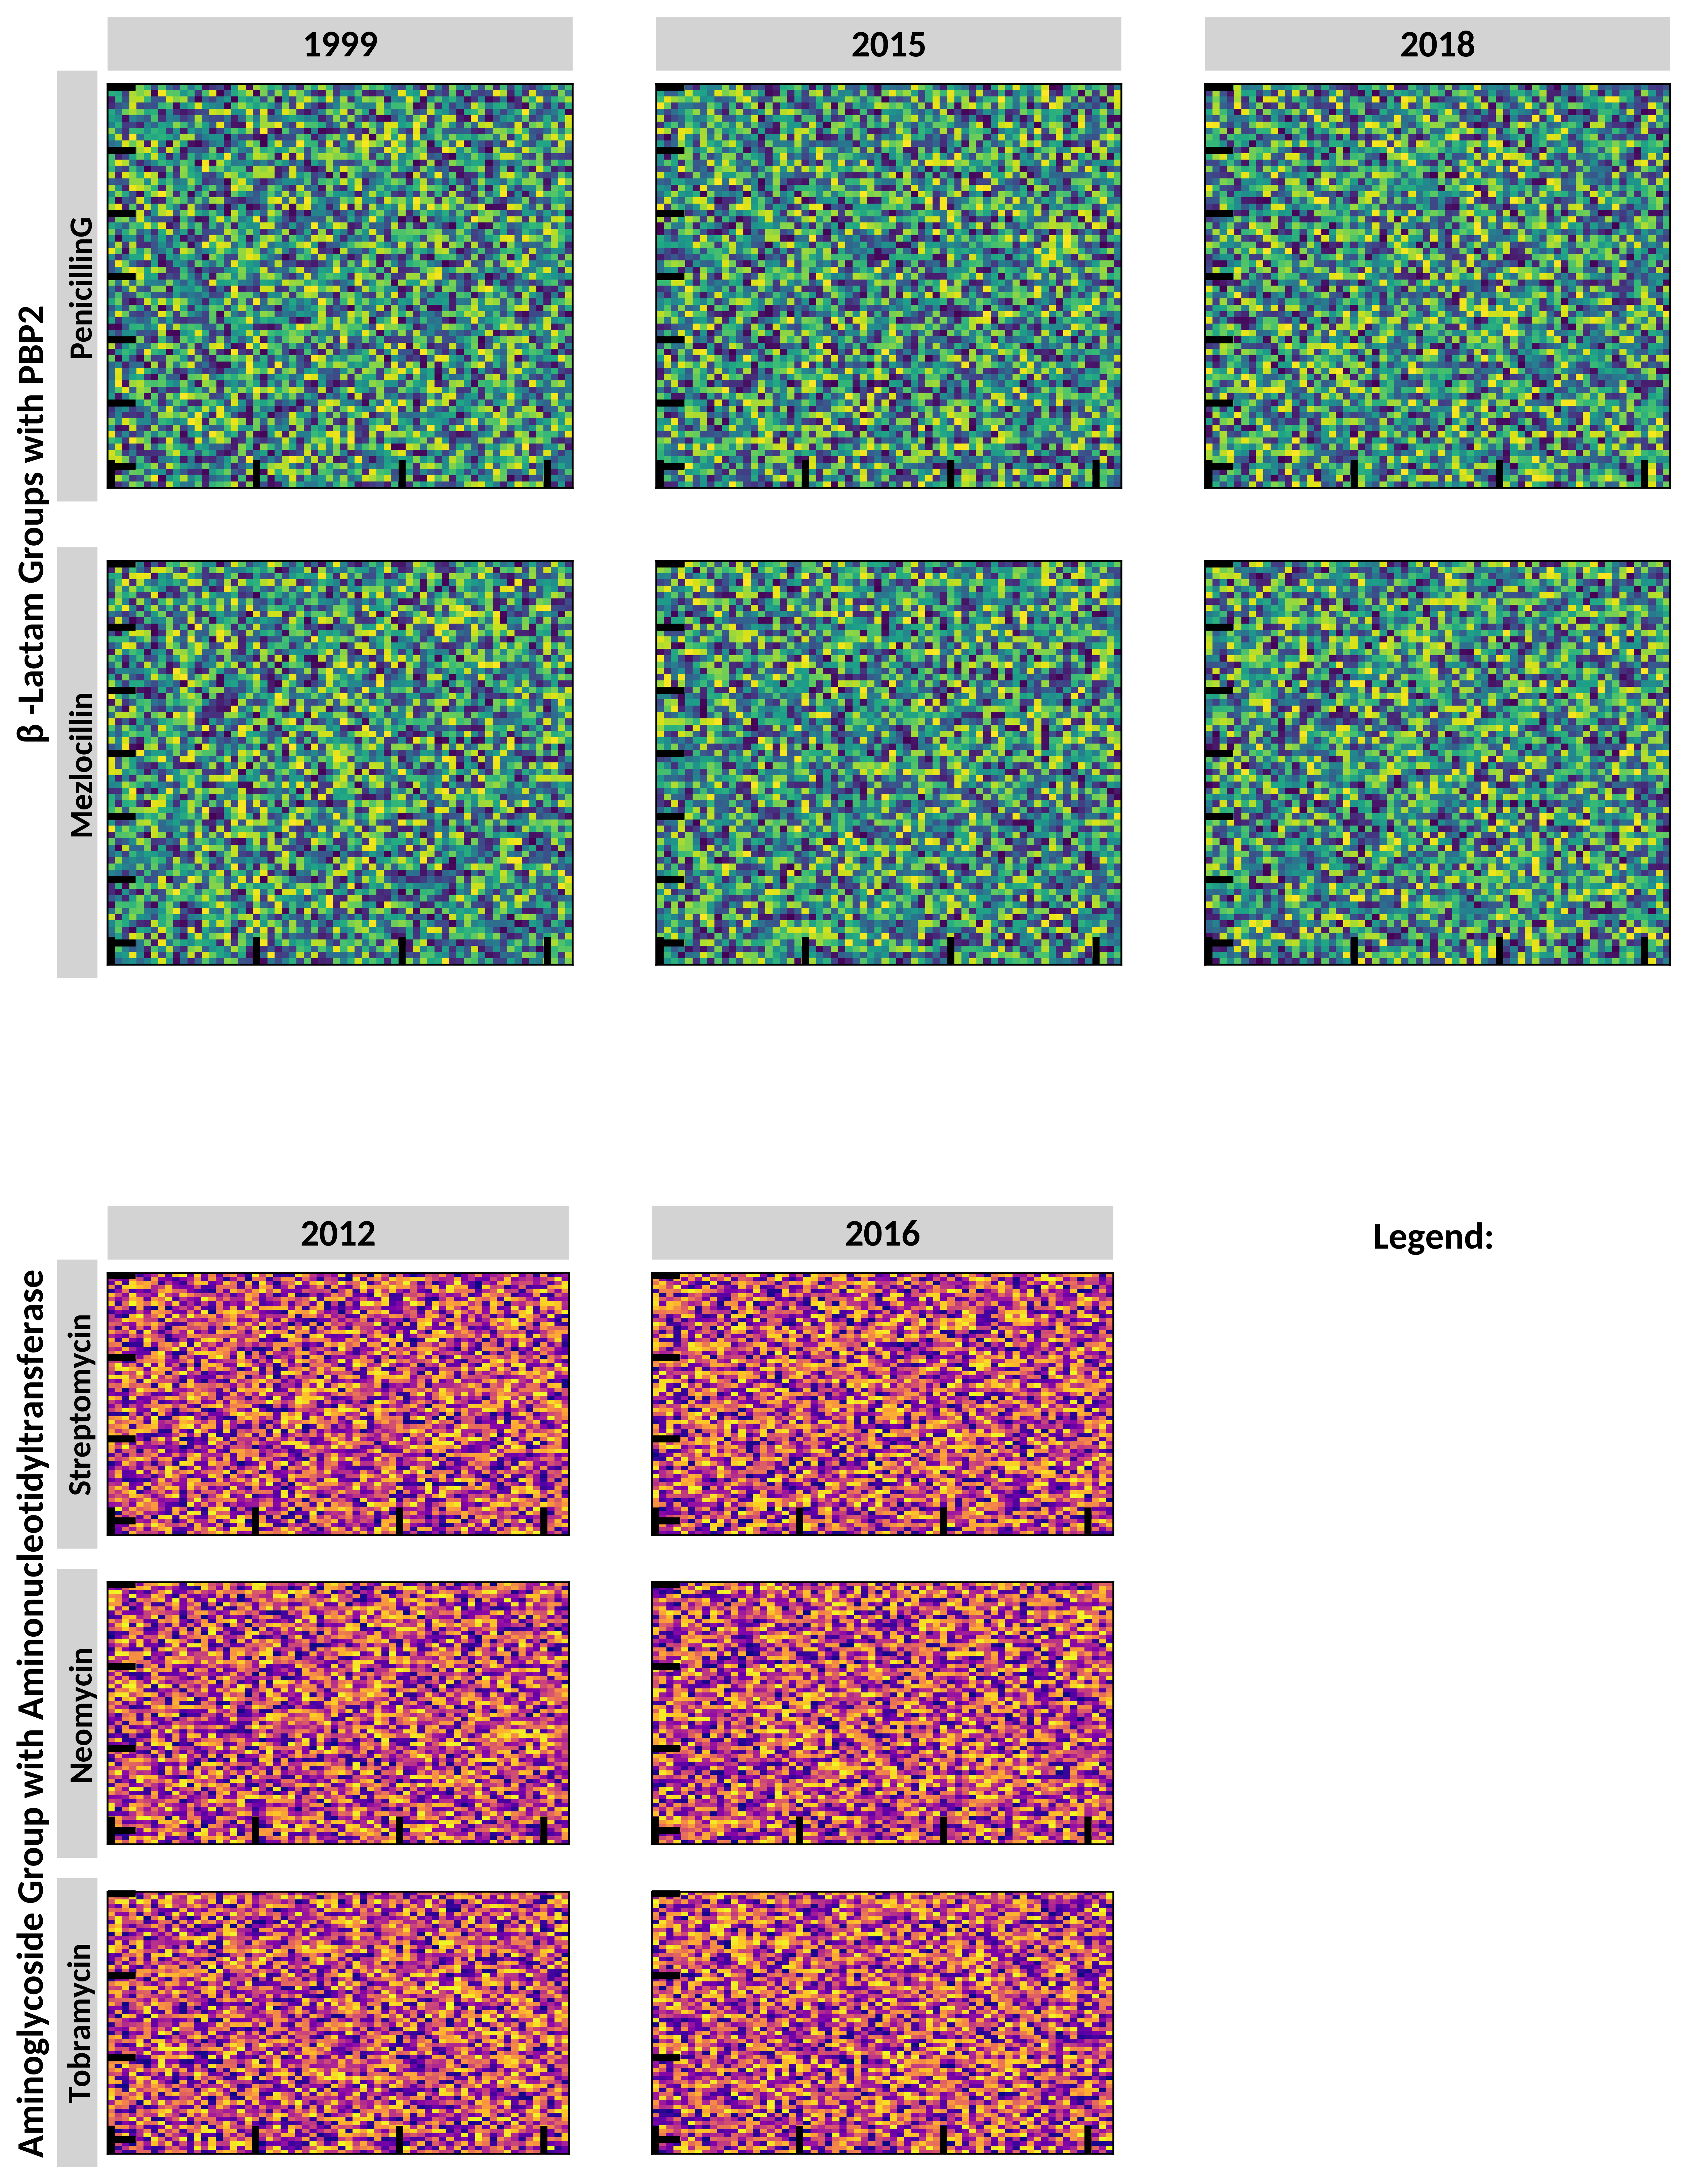

In [ ]:
# language: python

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Carlito'
mpl.rcParams['font.serif'] = ['Carlito']
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'stix'
# ensure matplotlib does not use external LaTeX for text rendering
mpl.rcParams['text.usetex'] = False
from matplotlib.patches import FancyBboxPatch

fig = plt.figure(figsize=(12, 16))
# Outer: left main area + right legend column
outer = GridSpec(nrows=1, ncols=2, width_ratios=[8, 2], wspace=0.06)

# Left area subdivided into top and bottom blocks
left_blocks = outer[0, :].subgridspec(nrows=2, ncols=1, height_ratios=[1, 1], hspace=0.35)

# Top block: 2 rows × 3 cols
top_gs = left_blocks[0].subgridspec(nrows=2, ncols=3, hspace=0.18, wspace=0.18)
top_axes = [[fig.add_subplot(top_gs[r, c]) for c in range(3)] for r in range(2)]


# Bottom block: 3 rows × 2 cols
left_blocks = outer[0, 0].subgridspec(nrows=2, ncols=6, height_ratios=[1, 1], hspace=0.35)
bot_gs = left_blocks[1,0:5].subgridspec(nrows=3, ncols=2, hspace=0.18, wspace=0.18)
bot_axes = [[fig.add_subplot(bot_gs[r, c]) for c in range(2)] for r in range(3)]

# Right legend / annotation column
legend_ax = fig.add_subplot(outer[0, 1])
legend_ax.axis('off')
legend_ax.text(0.02, 0.45, "Legend:", va='top', fontsize=16, weight='bold')

# Fill panels with placeholder content and hide axes ticks
for r in range(2):
    for c in range(3):
        ax = top_axes[r][c]
        ax.imshow(np.random.rand(64, 64), cmap='viridis', aspect='auto')
        #ax.axis('off')
        # hide axis label text (tick labels) but keep tick marks
        ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

for r in range(3):
    for c in range(2):
        ax = bot_axes[r][c]
        ax.imshow(np.random.rand(64, 64), cmap='plasma', aspect='auto')
        #ax.axis('off')
        # hide axis label text (tick labels) but keep tick marks
        ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

# Column headers for top block
top_years = ['1999', '2015', '2018']
for j, year in enumerate(top_years):
    pos = top_axes[0][j].get_position()
    cx = pos.x0 + pos.width / 2
    cy = pos.y1 + 0.008
    bb = FancyBboxPatch((pos.x0, cy-0.003), pos.width, 0.02,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(cx, cy, year, ha='center', va='bottom', fontsize=16, weight='bold')

# Column headers for bottom block
bot_years = ['2012','2016']
for j, year in enumerate(bot_years):
    pos = bot_axes[0][j].get_position()
    cx = pos.x0 + pos.width / 2
    cy = pos.y1 + 0.008
    bb = FancyBboxPatch((pos.x0, cy-0.003), pos.width, 0.02,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(cx, cy, year, ha='center', va='bottom', fontsize=16, weight='bold')

# Vertical group labels (left side)
top_block_pos = top_axes[1][0].get_position()  # middle row of top block
bot_block_pos = bot_axes[1][0].get_position()  # middle row of bottom block
# compute vertical centers from actual axes positions (fixes AttributeError)
top_positions = [top_axes[r][c].get_position() for r in range(len(top_axes)) for c in range(len(top_axes[0]))]
top_y0 = min(p.y0 for p in top_positions)
top_y1 = max(p.y1 for p in top_positions)
top_center = (top_y0 + top_y1) / 2

bot_positions = [bot_axes[r][c].get_position() for r in range(len(bot_axes)) for c in range(len(bot_axes[0]))]
bot_y0 = min(p.y0 for p in bot_positions)
bot_y1 = max(p.y1 for p in bot_positions)
bot_center = (bot_y0 + bot_y1) / 2

fig.text(0.08, top_center, "\u03B2 -Lactam Groups with PBP2",
        va='center', ha='left', rotation=90, fontsize=16, weight='bold')
fig.text(0.08, bot_center, "Aminoglycoside Group with Aminonucleotidyltransferase",
        va='center', ha='left', rotation=90, fontsize=16, weight='bold')

Ligand_names = ["PenicillinG", "Mezlocillin"]
for i, name in enumerate(Ligand_names):
    pos = top_axes[i][0].get_position()
    # Create a background box for the ylabel
    ylab_box = FancyBboxPatch(
        (pos.x0 - 0.025, pos.y0 - 0.005),        # slightly lower so it doesn't overlap the label
        0.02,
        pos.height + 0.01,                      # a hair taller to sit nicely behind the label
        boxstyle="round,pad=0.0",
        transform=fig.transFigure,
        facecolor="lightgray",
        edgecolor="k",
        linewidth=0,
        zorder=0                                 # draw underneath the axis label text
    )
    fig.add_artist(ylab_box)
    bb = FancyBboxPatch((pos.x0-0.025, pos.y0), 0.02, pos.height,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(pos.x0 - 0.02, pos.y0 + pos.height / 2, name,
            va='center', ha='left', rotation=90, fontsize=14, weight='bold')


Ligand_names = ["Streptomycin", "Neomycin" , "Tobramycin"]
for i, name in enumerate(Ligand_names):
    pos = bot_axes[i][0].get_position()
    # Create a background box for the ylabel
    ylab_box = FancyBboxPatch(
        (pos.x0 - 0.025, pos.y0 - 0.005),        # slightly lower so it doesn't overlap the label
        0.02,
        pos.height + 0.01,                      # a hair taller to sit nicely behind the label
        boxstyle="round,pad=0.0",
        transform=fig.transFigure,
        facecolor="lightgray",
        edgecolor="k",
        linewidth=0,
        zorder=0                                 # draw underneath the axis label text
    )
    fig.add_artist(ylab_box)
    bb = FancyBboxPatch((pos.x0-0.025, pos.y0), 0.02, pos.height,
                    boxstyle="round,pad=0.0",
                    transform=fig.transFigure,
                    facecolor="lightgray", edgecolor="k", linewidth=0)
    fig.add_artist(bb)
    fig.text(pos.x0 - 0.02, pos.y0 + pos.height / 2, name,
            va='center', ha='left', rotation=90, fontsize=14, weight='bold')

#plt.savefig("layout_example.svg", dpi=300, bbox_inches='tight')
plt.show()